# Traffic Signs Recognition

### Image Processing
### Teodor Kanev

## 1. The task


Self-driving cars looks possible, but still there are many problematic areas around inventing them. They must be absolutely safe for everyone on the road and follow road rules. Last is impossible if cars are unable to see and recognize traffic signs. Main goal for this notebook is to create an application, which is able to classify traffic signs. This problem has been studied for a decade now and pretty good results have been accomplished.

## 2. Data preparation

Data chosen for the task can be found here: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign <br> It is consisted of 50,000+ images containing only one traffic sign in 43 categories. It is split of Train and Test set.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
def load_meta_data(folder):
    metaFolder = os.path.join(folder, "Meta")
    images = []
    for filename in sorted(os.listdir(metaFolder)):
        img = Image.open(os.path.join(metaFolder, filename))
        if img is not None:
            images.append(np.array(img))
    return images

In [3]:
data_folder = "Data"

In [4]:
meta_images = load_meta_data(data_folder)

Let's show all 43 categories we can classify

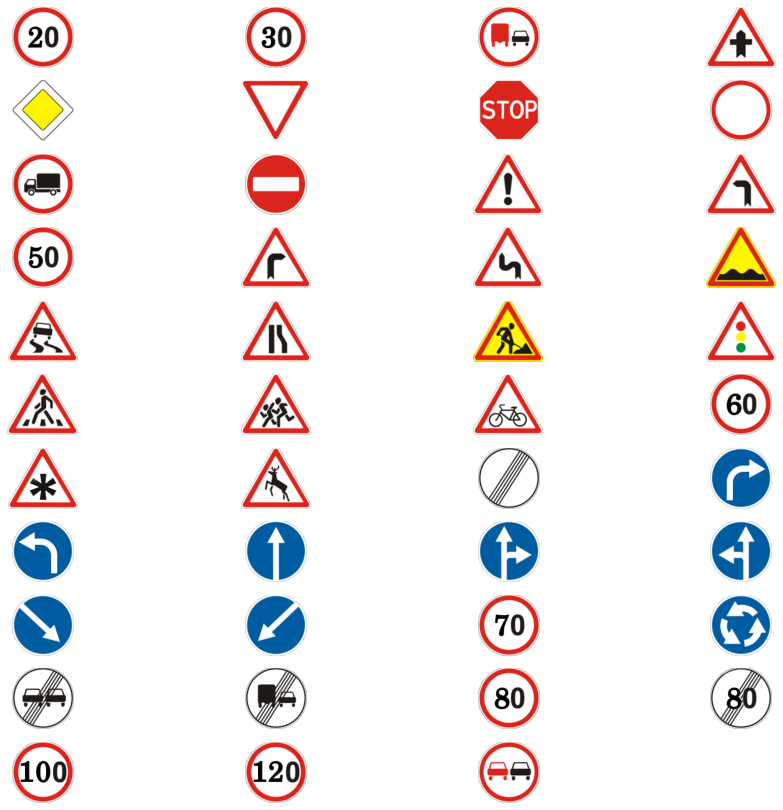

In [5]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(meta_images)):
    fig.add_subplot(12, 4, i+1)
    plt.imshow(meta_images[i])
    plt.axis('off')
plt.show()

Load train data. When reading every image, resize it to 32x32 pixels, as we need consistent image representation to train a model.

In [6]:
def load_train_data(folder):
    images = []
    labels = []
    train_folder = os.path.join(folder,"Train")
    index = 0
    folders = len(os.listdir(train_folder))
    for category in range(folders):
        categoryPath = os.path.join(train_folder, str(category))
        for filename in sorted(os.listdir(categoryPath)):
            img = Image.open(os.path.join(categoryPath, filename))
            if img is not None:
                resized_img = img.resize((32, 32), Image.ANTIALIAS)
                images.append(np.array(resized_img))
                labels.append(category)
                index += 1
    return images, labels

In [105]:
train_images, train_labels = load_train_data(data_folder)

In [119]:
np.random.seed(7777)
random_training_sample = np.random.randint(len(train_images), size=10)

Let's see a random sample of our training images

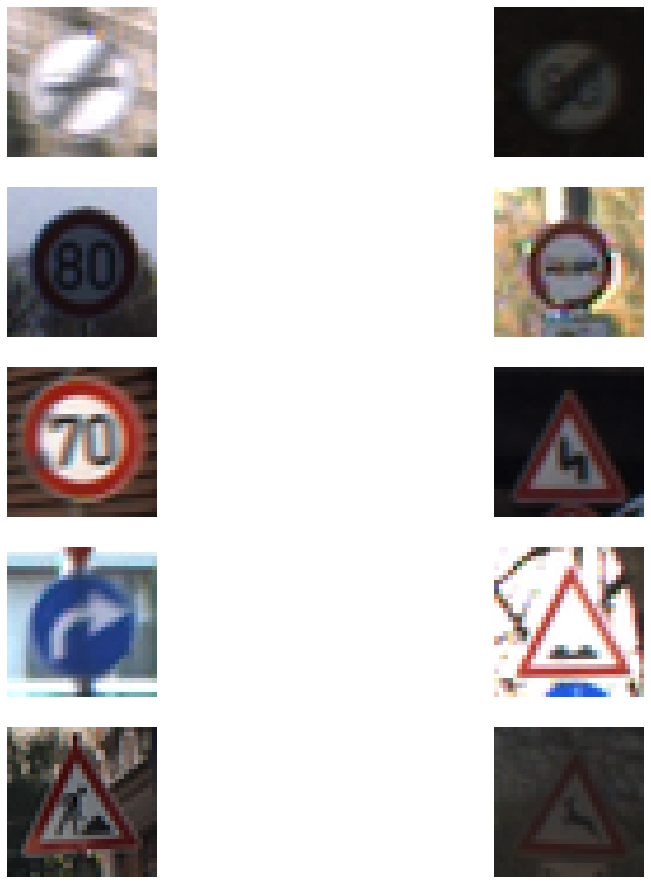

In [120]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(random_training_sample)):
    fig.add_subplot(5, 2, i+1)
    plt.imshow(train_images[random_training_sample[i]])
    plt.axis('off')
plt.show()

We see that there are images with bad quality and contrast. It is important to see how classes are distributed in train set.

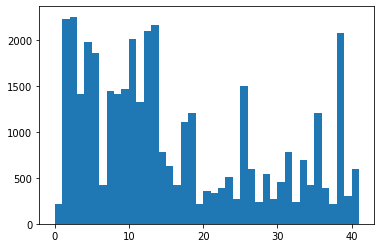

In [10]:
plt.hist(train_labels, bins = range(0,42))
plt.show()

Image classes distribution is not perfectly balanced, but it is good enough for training a model

Let's load test data and resize every test image to 32x32 pixels. This is needed, as our model needs input image of the exact same size.

In [11]:
def load_test_data(data_folder):
    test_csv_path = os.path.join(data_folder, "Test.csv")
    test_df = pd.read_csv(test_csv_path)
    test_df = test_df[['Path', 'ClassId']]
    dataframe_len = len(test_df)
    paths_list = list(test_df['Path'])
    test_labels = list(test_df['ClassId'])
    test_images = []
    for i in range(dataframe_len):
        filename = paths_list[i]
        img = Image.open(os.path.join("Data", filename))
        if img is not None:
            resized_img = img.resize((32,32), Image.ANTIALIAS)
            test_images.append(np.array(resized_img))
    return test_images, test_labels

In [12]:
test_images, test_labels = load_test_data(data_folder)

Let's show a random sample of test images

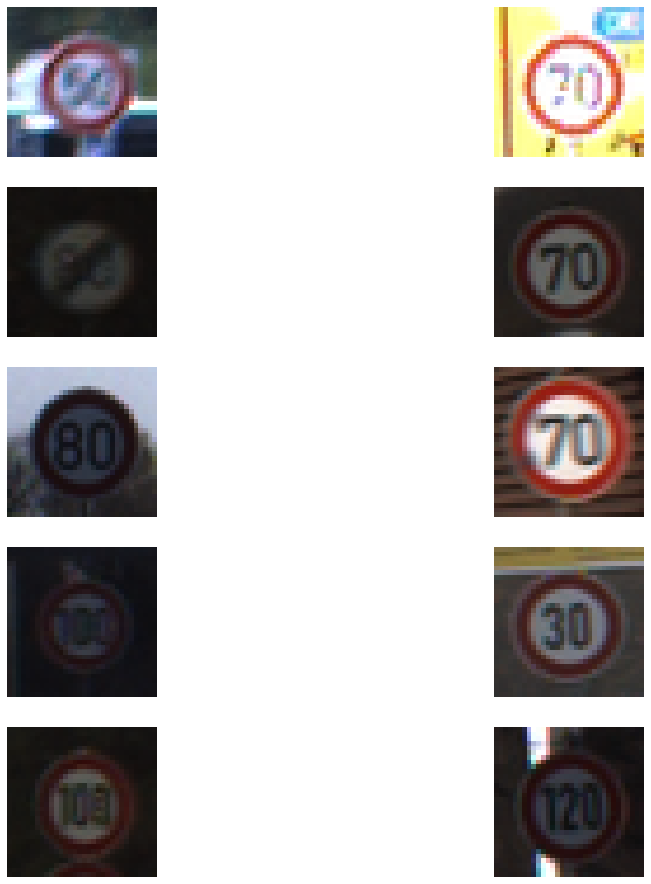

In [13]:
np.random.seed(7777)
random_test_sample = np.random.randint(len(test_images), size=10)
fig = plt.figure(figsize=(16, 16))
for i in range(len(random_test_sample)):
    fig.add_subplot(5, 2, i+1)
    plt.imshow(train_images[random_test_sample[i]])
    plt.axis('off')
plt.show()

Test images are real case scenario images. Some are with low quality and some are made at night

Overall we have train and test set of 32x32 images with lengths:

In [14]:
print("Train set size:",len(train_images) ,"images.")
print("Test set size:",len(test_images) ,"images.")

Train set size: 39209 images.
Test set size: 12630 images.


We will split some of the train images to create a validation set. To be more precise: about 20% of the current train set will be used as validation set, and only 80% of training one. First let's random shuffle all images, as they are sorted by classes in the current data.

In [15]:
from sklearn.utils import shuffle
train_images_shuffled, train_labels_shuffled = shuffle(train_images, train_labels, random_state = 7777)
test_images_shuffled, test_labels_shuffled = shuffle(test_images, test_labels, random_state = 7777)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    train_images_shuffled, train_labels_shuffled, test_size=0.2, random_state=7777)

Transform data in numpy array with 4 dimesions: <br> 


In [17]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val) 
Y_val = np.array(Y_val)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

## 3. Model architecture and training

In this section we will create a neural network, train it and use validation set to fine-tune it. Below is presented only the best parameters of this phase. 

Before we put the train data in a model, we need one more thing to do. Categories in data set are integers. What we need for our classification task is to have one-hot-encoding vectors instead. This is a vector with 0 in every dimension, and only one 1 in the dimension, which corresponds to the class for a training example. <br>
<b> Important: Prediction of an image will also be a one-hot encoding vector

In [18]:
example_category = Y_train[0]

In [19]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

/home/lypon/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [20]:
print("Class", example_category, "is now represented as:", Y_train[0])

Class 8 is now represented as: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


It is time to build a model using keras

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
seed_value = 7777
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
tf.random.set_seed(seed_value)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [23]:
model = keras.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))
model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation = "relu"))
model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation = "relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding="valid"))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.PReLU())
model.add(layers.Dense(43, activation = 'softmax'))

model.summary()
model.compile(optimizer="SGD", loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [54]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=1, batch_size=64)

Epoch 1/10
491/491 [==============================] - 175s 357ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.0592 - val_accuracy: 0.9862
Epoch 2/10
491/491 [==============================] - 159s 324ms/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.0196 - val_accuracy: 0.9955
Epoch 3/10
491/491 [==============================] - 152s 309ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9960
Epoch 4/10
491/491 [==============================] - 145s 295ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9959
Epoch 5/10
491/491 [==============================] - 143s 291ms/step - loss: 9.6109e-04 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9958
Epoch 6/10
491/491 [==============================] - 124s 253ms/step - loss: 7.6356e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9955
Epoch 7/10
491/491 [==============================] - 126s 257ms/step - loss: 6.9368e-04 - accuracy: 1.0000 - val_lo

In [55]:
predict = model.predict(X_test)

In [56]:
def accuracy(Y_test, predict):
    return np.sum(np.argmax(predict, axis = 1)  == np.argmax(Y_test, axis=1)) / len(predict)

In [57]:
accuracy(Y_test, predict)

0.9631037212984956

Let's see some images that our model failed to classify correctly

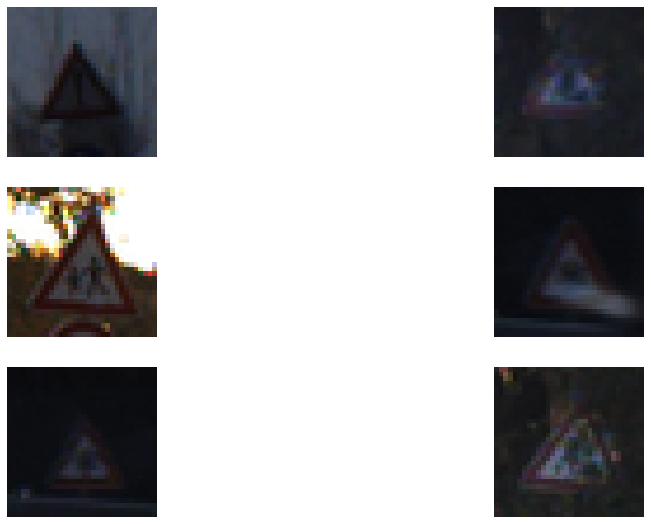

In [58]:
wrong_predictions = X_test[np.argmax(predict, axis = 1)  != np.argmax(Y_test, axis=1)]
fig = plt.figure(figsize=(16, 16))
for i in range(6):
    fig.add_subplot(5, 2, i+1)
    plt.imshow(wrong_predictions[i])
    plt.axis('off')
plt.show()

We may conclude that most of wrong predicted images cannot be correctly classified even by human. Reason for this is bad image quality. Let's try to equalize their histogram and train the model again.

In [59]:
import cv2

In [60]:
def newImage(image):
    colored = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    x, y, z = colored.shape
    brightness_matrix = colored[:,:,2]
    brightness_matrix_equalized = cv2.equalizeHist(brightness_matrix)
    colored_equalized = colored.copy()
    for i in range(x):
        for j in range(y):
            colored_equalized[i,j,2] = brightness_matrix_equalized[i,j]
    colored_equalized_RGB = cv2.cvtColor(colored_equalized, cv2.COLOR_HSV2RGB)
    return colored_equalized_RGB

In [61]:
X_train_hist = X_train.copy()
X_val_hist = X_val.copy()
X_test_hist = X_test.copy()
for i in range(0,len(X_train_hist)):
    X_train_hist[i] = newImage(X_train[i])
for i in range(0,len(X_val_hist)):
    X_val_hist[i] = newImage(X_val[i])
for i in range(0,len(X_test_hist)):
    X_test_hist[i] = newImage(X_test[i])

In [62]:
model_hist = model

In [63]:
model_hist.fit(X_train_hist, Y_train, epochs=10, validation_data=(X_val_hist, Y_val), verbose=1, batch_size=64)

Epoch 1/10
491/491 [==============================] - 119s 243ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0294 - val_accuracy: 0.9932
Epoch 2/10
491/491 [==============================] - 131s 267ms/step - loss: 6.4660e-04 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 0.9940
Epoch 3/10
491/491 [==============================] - 121s 246ms/step - loss: 4.1930e-04 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9940
Epoch 4/10
491/491 [==============================] - 119s 242ms/step - loss: 3.4763e-04 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9944
Epoch 5/10
491/491 [==============================] - 117s 238ms/step - loss: 3.0115e-04 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9944
Epoch 6/10
491/491 [==============================] - 113s 230ms/step - loss: 2.7334e-04 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9944
Epoch 7/10
491/491 [==============================] - 113s 230ms/step - loss: 2.4722e-04 - accuracy: 1.0

In [64]:
predict_hist = model_hist.predict(X_test_hist)

In [65]:
accuracy(Y_test, predict_hist)

0.9559778305621536

## 4. Model Visualization

In [90]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 32, 32, 64)
1 conv2d_1 (None, 16, 16, 64)
2 conv2d_2 (None, 16, 16, 64)


In [92]:
layer_index_list = [0,1,2]
outputs = [model.layers[i].output for i in layer_index_list]
model_visualization = keras.Model(inputs=model.inputs, outputs=outputs)
model_visualization.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
Total params: 78,720
Trainable params: 78,720
Non-trainable params: 0
_________________________________________________________________


Let's take a image from test data and try to explain how does the model classify it

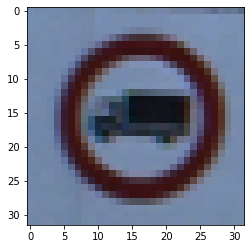

In [121]:
plt.imshow(X_test[0])

In [122]:
preprocessed_img_test = np.expand_dims(X_test[0], axis=0)

In [123]:
feature_maps = model_visualization.predict(preprocessed_img_test)

In [124]:
for i in feature_maps:
    print(i.shape)

(1, 32, 32, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)


In [125]:
def visualize_feature_maps(feature_maps):
    square_size = 8
    for fmap in feature_maps:
        fig = plt.figure(figsize=(16, 16))
        print('\n')
        for i in range(square_size * square_size):
            ax = plt.subplot(square_size, square_size, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0, :, :, i], cmap='gray')
        plt.show()

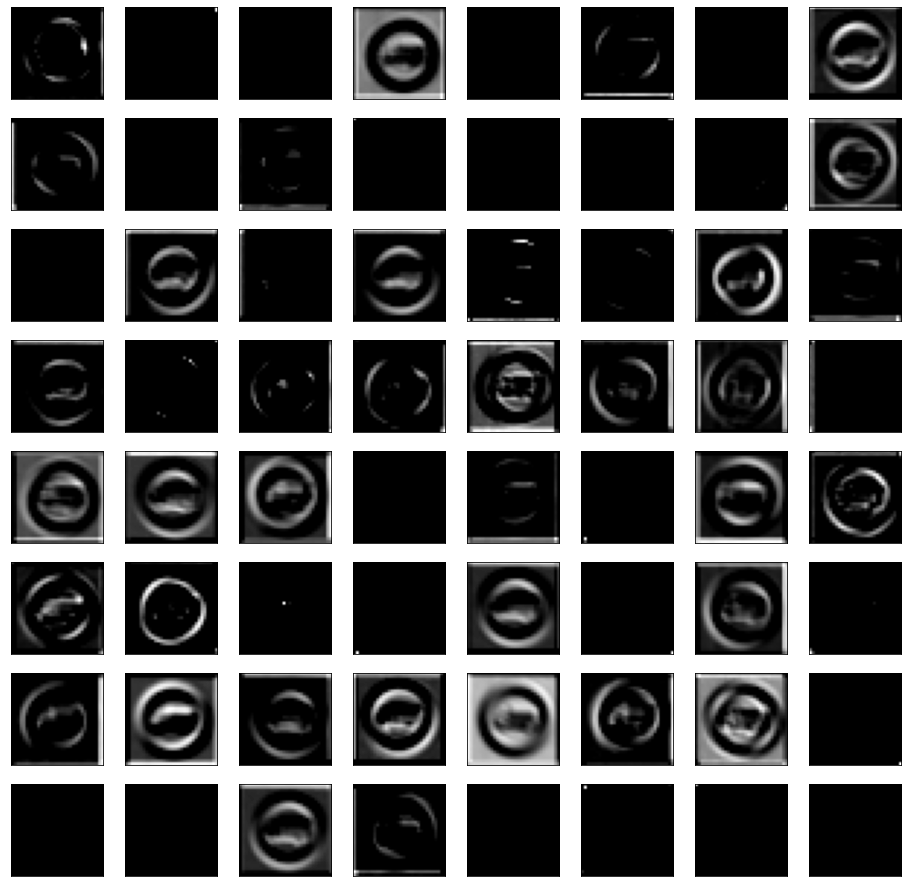

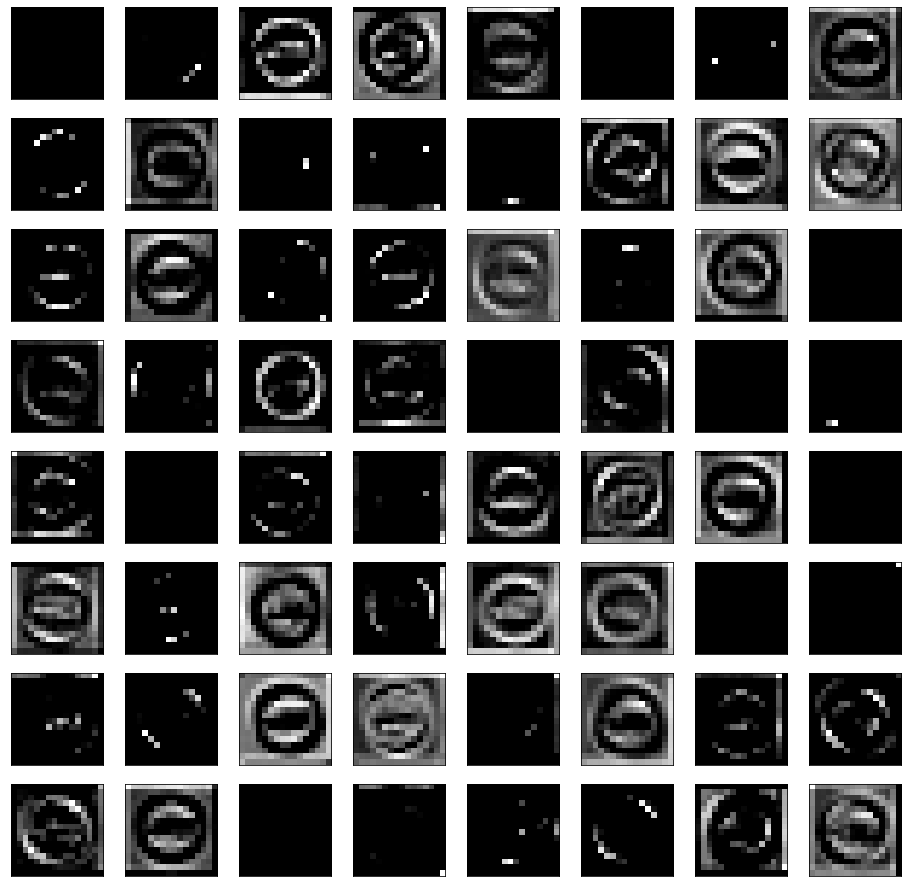

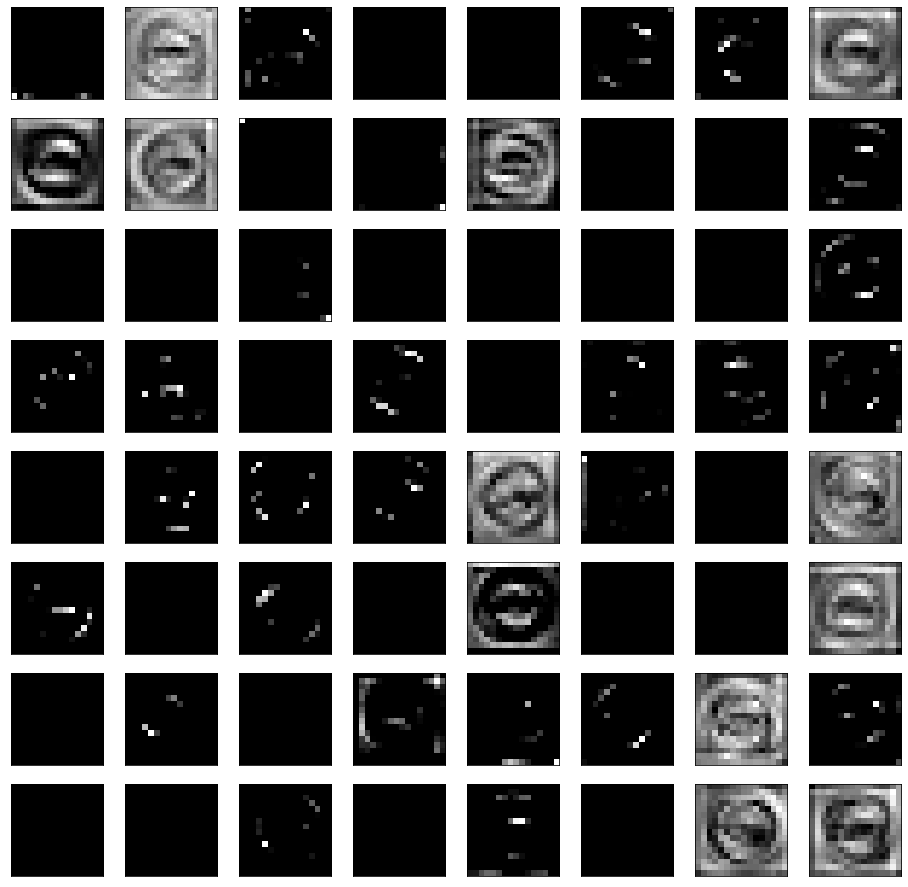

In [126]:
visualize_feature_maps(feature_maps)

The same process with other image

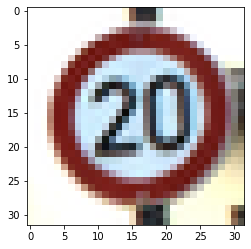

In [127]:
plt.imshow(X_train[2])

In [128]:
preprocessed_img_train = np.expand_dims(X_train[2], axis=0)

In [129]:
feature_maps = model_visualization.predict(preprocessed_img_train)

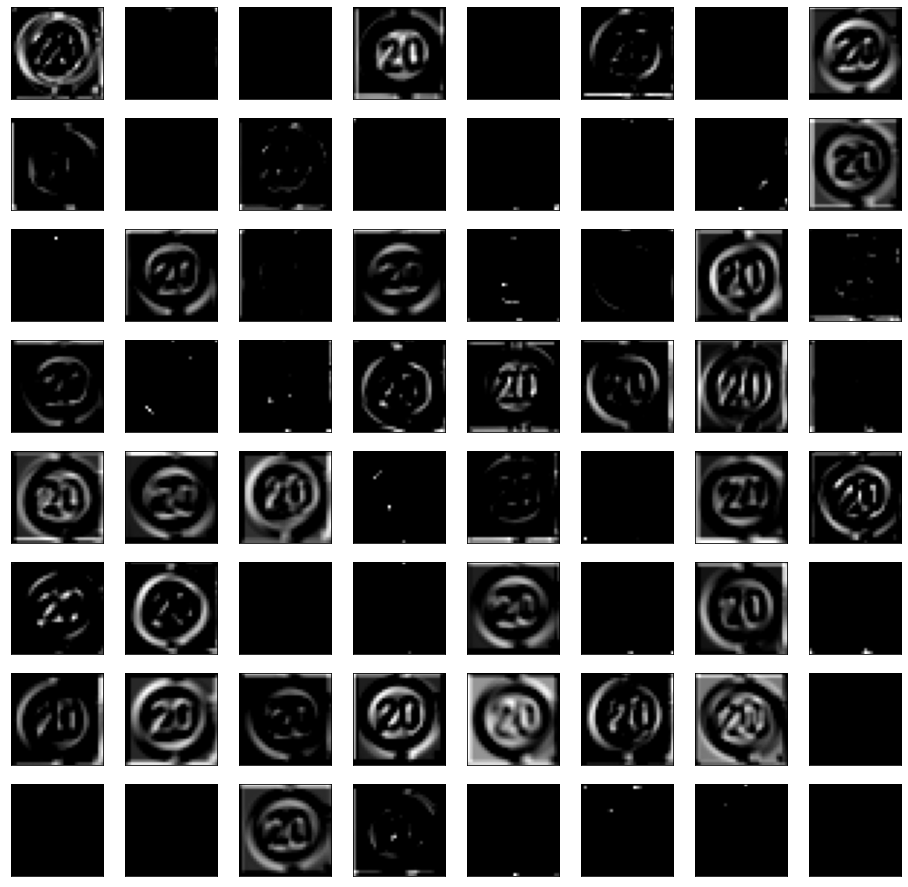

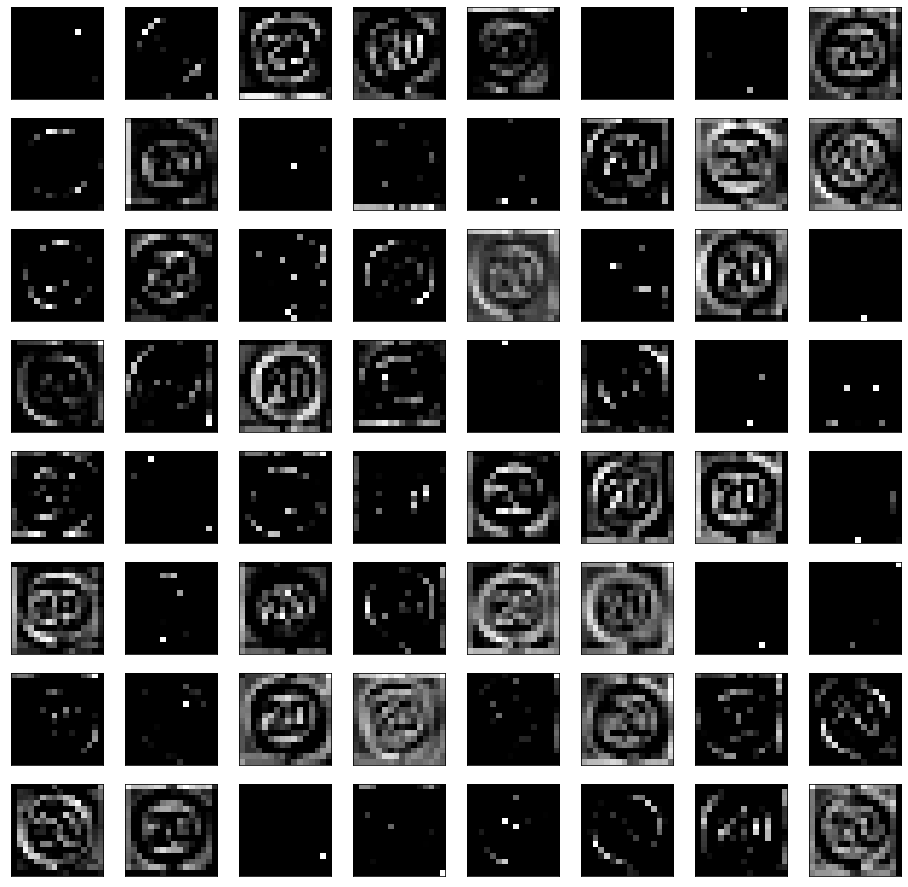

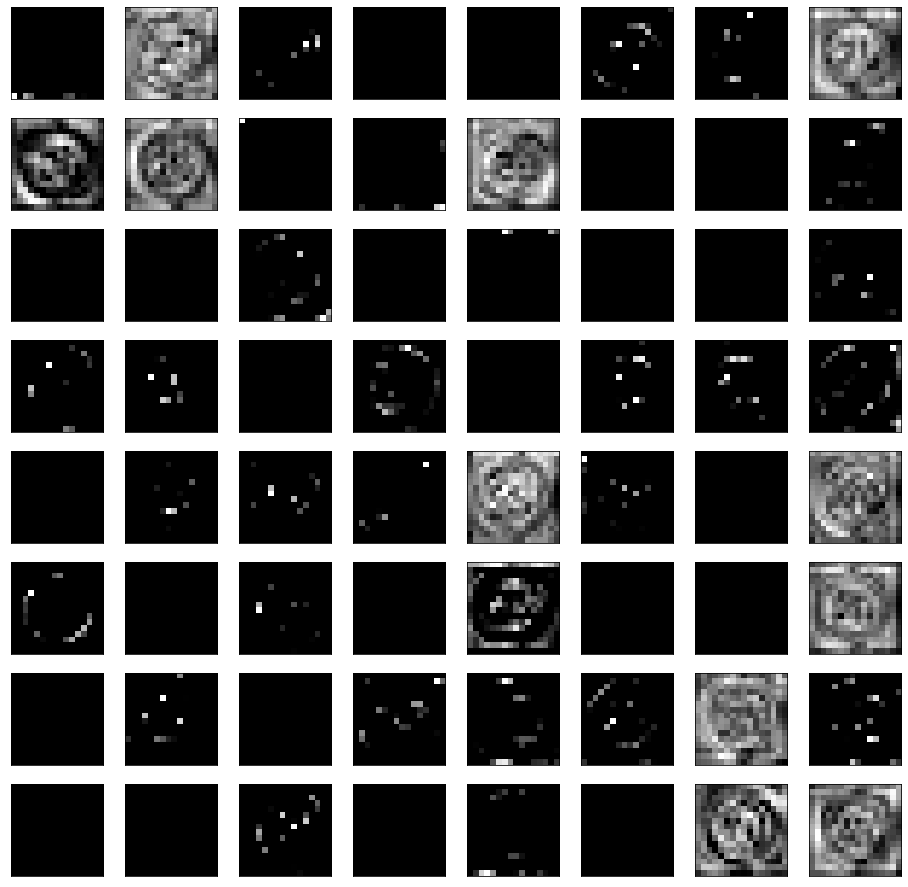

In [130]:
visualize_feature_maps(feature_maps)

## 5. Comparing results with other projects

This task has been used for IJCNN 2011 contest - final results can be found here https://benchmark.ini.rub.de/gtsrb_results_ijcnn.html

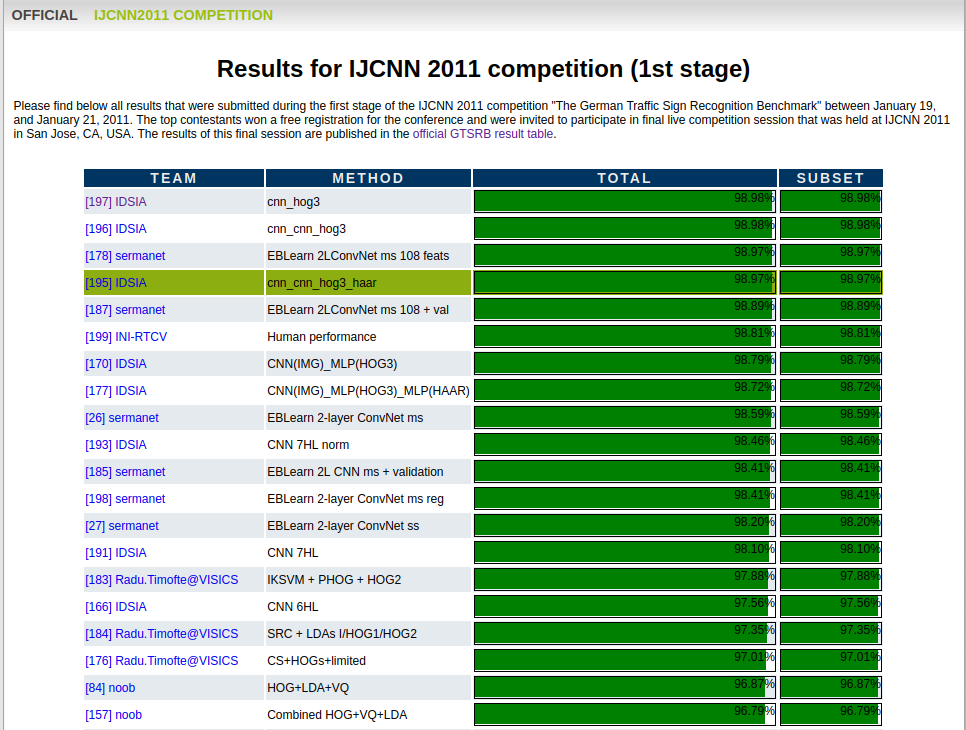

We can see that first ranked model has almost 99% accuracy. Convolutional Neural Network is actually the most used methods for traffic sign recognition. That means we chose a good approach to the problem, expect for more accuracy either a more complicated, or more optimized architecture is needed. We see that our result isn't far away from top ranks, but we should take it into consideration that the competition was held in 2011.

Interesting observation is that some competitor actually tried to normalize images histogram and apply LDA algorithm afterwards.

## 6. References

#### 1. Keras API Documentation - https://keras.io/
#### 2. CNN Feature Visualization - https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
#### 3. Dataset and Task Competiton - https://benchmark.ini.rub.de/gtsrb_news.html